# DATASCIENCE HACKATHON 2021
# Forcasting Challenge(Cost)

In [80]:
# Importing Libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error
import ast
import miceforest as mf
from collections import Counter
import sklearn
from sklearn import metrics
import statsmodels.formula.api as smf
import pickle
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean

## 1. Understanding Dataset

In [2]:
# Loading dataset

data = pd.read_excel("DataScienceHackathonTrainingData.xlsx")

In [3]:
# Training Data Overview

data.head(5)

,Date,BaseDemand,Demand,Availability,Event,Cost
0,2011-01-01 00:10:00,10.002507,92.002400,89.995956,1.0,NaN
1,2011-01-01 00:20:00,9.992000,92.004340,89.997298,1.0,NaN
2,2011-01-01 00:30:00,NaN,92.008667,89.997397,1.0,NaN
3,2011-01-01 00:40:00,NaN,92.010055,NaN,1.0,NaN
4,2011-01-01 00:50:00,9.991615,92.001876,89.993375,1.0,14.000028


In [6]:
# Checking shape of data

print("The shape of entire training data given is: ",data.shape)

The shape of entire training data given is:  (416666, 6)


In [5]:
# Variable Datatype Identification

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416666 entries, 0 to 416665
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          416666 non-null  datetime64[ns]
 1   BaseDemand    312500 non-null  float64       
 2   Demand        312500 non-null  float64       
 3   Availability  312500 non-null  float64       
 4   Event         312500 non-null  float64       
 5   Cost          312500 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 19.1 MB


The data has 416666 records accross 6 attributes. The attributes are Date, BaseDemand, Demand, Availability, Event and Cost. Cost being the response variable and other 5 are predictors.

In testing data we have 5 attributes and 800 records.

Date: Format YYYY-DD-MM HH:MM:SS It specifies the time at which we what to check the cost for. 

BaseDemand: BaseDemand is numerical variable.

Demand: Demand is numerical variable

Availability: Availability is a numerical variable specifying the available value.

Event: Event is also a numerical variable but seems taking only 4 values 1,2,3 and 4.

Cost: Cost is the response variable that is numerical and needs to be predicted based on the above 5 predictors.

In [7]:
# Checking Missing Values

data.isnull().sum()

Date                 0
BaseDemand      104166
Demand          104166
Availability    104166
Event           104166
Cost            104166
dtype: int64

In [9]:
# Creating 2 new datasets from original dataset. #1: Having no missing values on response; #2: Having missing values on response

notnull_data = data[data['Cost'].notnull()]
null_data = data[~(data['Cost'].notnull())]
notnull_data.shape, null_data.shape

((312500, 6), (104166, 6))

In [10]:
# Checking the shape of all datasets

print("The shape of entire training data given is: ",data.shape)
print("The shape of generated dataset having no null values in Cost variable: ",notnull_data.shape)
print("The shape of generated dataset having null values in Cost variable: ",null_data.shape)

The shape of entire training data given is:  (416666, 6)
The shape of generated dataset having no null values in Cost variable:  (312500, 6)
The shape of generated dataset having null values in Cost variable:  (104166, 6)


In [11]:
# Creating 2 new datasets from notnull dataset. #1: Training Set; #2: Validation Set

train_data, val_data = train_test_split(notnull_data, test_size = 0.2 , random_state = 10)

In [12]:
# Checking the shape of all datasets

print("The shape of entire training data given is: ",data.shape)
print("The shape of generated dataset having no null values in Cost variable is: ",notnull_data.shape)
print("The shape of generated dataset having null values in Cost variable is: ",null_data.shape)
print("The shape of generated training dataset is : ",train_data.shape)
print("The shape of generated validation dataset is: ",val_data.shape)

The shape of entire training data given is:  (416666, 6)
The shape of generated dataset having no null values in Cost variable is:  (312500, 6)
The shape of generated dataset having null values in Cost variable is:  (104166, 6)
The shape of generated training dataset is :  (250000, 6)
The shape of generated validation dataset is:  (62500, 6)


## 2. Exploratory Data Analysis

### A. Univariate Analysis

In [13]:
# Train Data Statistics

train_data.describe()

,BaseDemand,Demand,Availability,Event,Cost
count,187453.000000,187470.000000,187684.000000,187375.000000,250000.000000
mean,10.085222,98.412140,92.263601,1.259581,52.907146
std,0.693905,2.565199,1.225204,0.759234,25.708329
min,8.965338,91.195384,89.815953,1.000000,11.525820
25%,9.402660,96.486784,91.501088,1.000000,29.686697
50%,10.168315,99.710223,92.028334,1.000000,54.118041
75%,10.763432,100.125586,92.799221,1.000000,73.726808
max,11.039833,101.425274,95.414218,4.000000,122.975852


In [14]:
# Validation Data Statistics

val_data.describe()

,BaseDemand,Demand,Availability,Event,Cost
count,46941.000000,46900.000000,46786.000000,46742.000000,62500.000000
mean,10.075301,98.410250,92.257808,1.258440,52.870746
std,0.694146,2.565299,1.225521,0.760119,25.736132
min,8.970648,91.190235,89.812940,1.000000,11.566570
25%,9.393100,96.495439,91.497695,1.000000,29.526158
50%,10.147272,99.704321,92.021085,1.000000,54.057934
75%,10.757761,100.125399,92.790827,1.000000,73.805460
max,11.030971,101.420189,95.408342,4.000000,122.876846


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


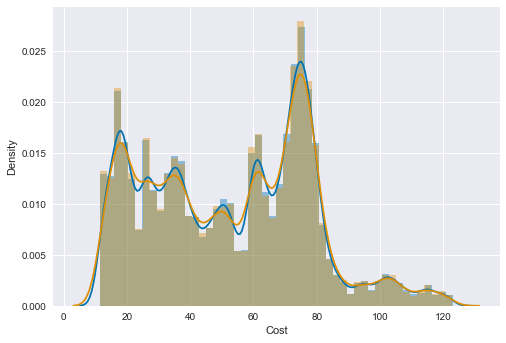

In [15]:
# Checking distribution of Response variable which is Revenue

sns.set_palette("colorblind")

sns.distplot(train_data.Cost)
sns.distplot(val_data.Cost)

plt.show()

Revenue variable has a bimodal distribution, we need to transform this variable to normal distribution. 

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


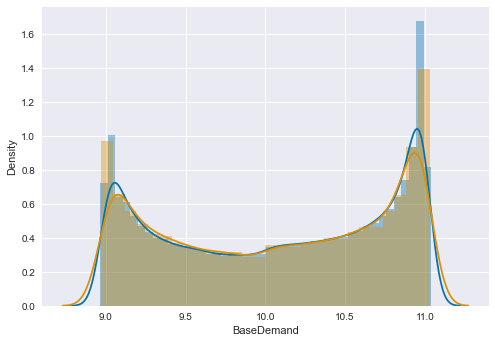

In [16]:
# Checking distribution of BaseDemand in Training Data

sns.set_palette("colorblind")

sns.distplot(train_data.BaseDemand)
sns.distplot(val_data.BaseDemand)

plt.show()

BaseDemand variable is also a bimodal distribution and needs transformation.

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


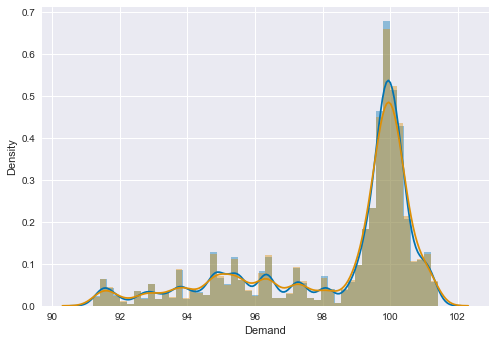

In [17]:
# Checking distribution of Demand in Training Data

sns.set_palette("colorblind")

sns.distplot(train_data.Demand)
sns.distplot(val_data.Demand)

plt.show()

Demand variable is a skewed variable so even this variable needs transformation.

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


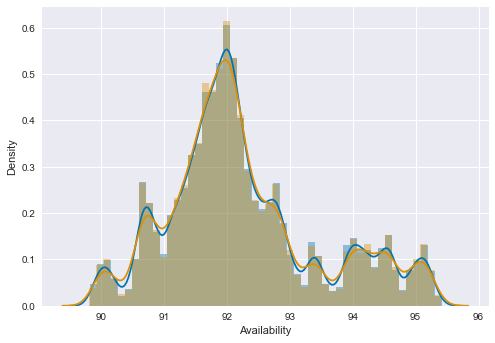

In [18]:
# Checking distribution of Availability in Training Data

sns.set_palette("colorblind")

sns.distplot(train_data.Availability)
sns.distplot(val_data.Availability)

plt.show()

Availability is a variable which is fairly normally distributed but has some inconsistencies. 

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


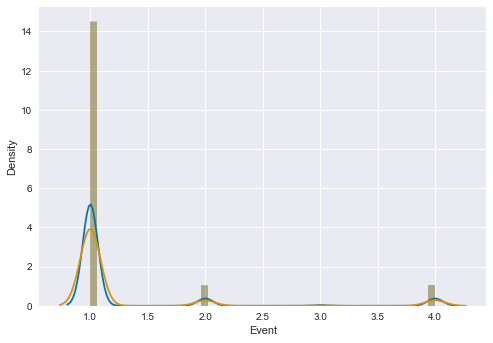

In [19]:
# Checking distribution of Availability in Training Data

sns.set_palette("colorblind")

sns.distplot(train_data.Event)
sns.distplot(val_data.Event)

plt.show()

Event variable takes whole numbers like 1,2,3,4. So we will be treating this as categorical variable. 

In [20]:
# Checking unique values in Event variable

unique_event = data['Event'].unique()
print(unique_event)

[ 1. nan  2.  4.  3.]


In [21]:
# Checking the categories resent in Event variable and seeing count against them

train_data.groupby('Event')['Event'].agg('count')

Event
1.0    163037
2.0     11734
3.0       907
4.0     11697
Name: Event, dtype: int64

In [22]:
# Checking the categories resent in Event variable and seeing count against them

val_data.groupby('Event')['Event'].agg('count')

Event
1.0    40752
2.0     2834
3.0      222
4.0     2934
Name: Event, dtype: int64

In [23]:
# Checking missing values in training dataset

train_data.isnull().sum()

Date                0
BaseDemand      62547
Demand          62530
Availability    62316
Event           62625
Cost                0
dtype: int64

<AxesSubplot:>

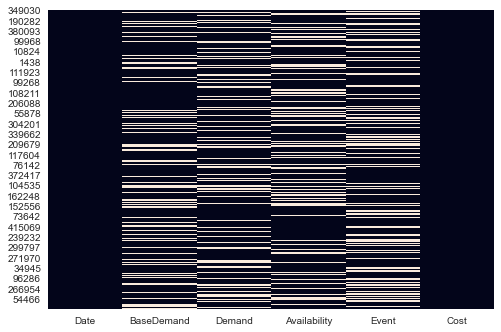

In [24]:
sns.heatmap(train_data.isnull(), cbar=False)

In [25]:
# Checking missing values in training dataset

val_data.isnull().sum()

Date                0
BaseDemand      15559
Demand          15600
Availability    15714
Event           15758
Cost                0
dtype: int64

<AxesSubplot:>

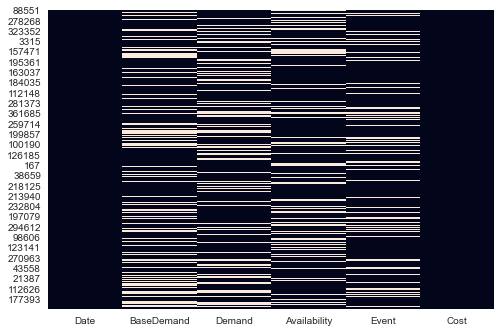

In [26]:
sns.heatmap(val_data.isnull(), cbar=False)

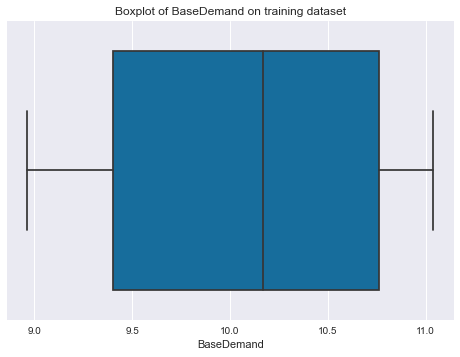

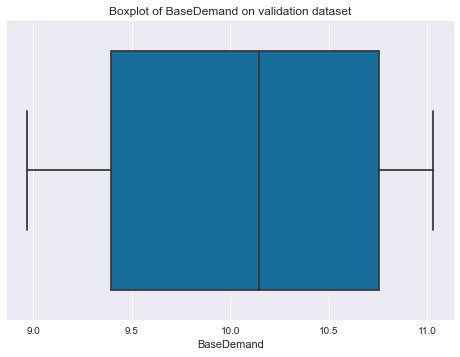

In [27]:
# Checking outliers in training dataset for BaseDemand Variable

plt.title('Boxplot of BaseDemand on training dataset')
sns.boxplot(x=train_data['BaseDemand'])
plt.show()
plt.title('Boxplot of BaseDemand on validation dataset')
sns.boxplot(x=val_data['BaseDemand'])
plt.show()

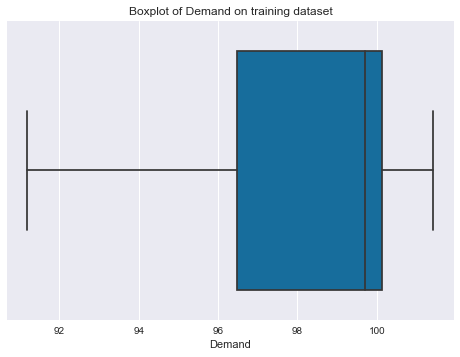

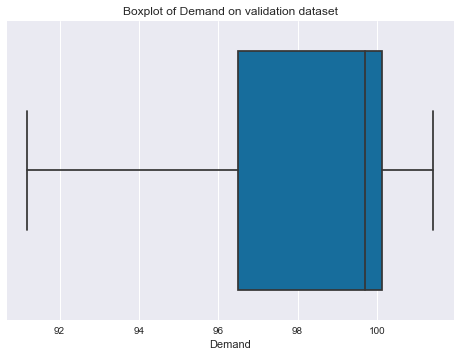

In [28]:
# Checking outliers in training dataset for Demand Variable

plt.title('Boxplot of Demand on training dataset')
sns.boxplot(x=train_data['Demand'])
plt.show()
plt.title('Boxplot of Demand on validation dataset')
sns.boxplot(x=val_data['Demand'])
plt.show()

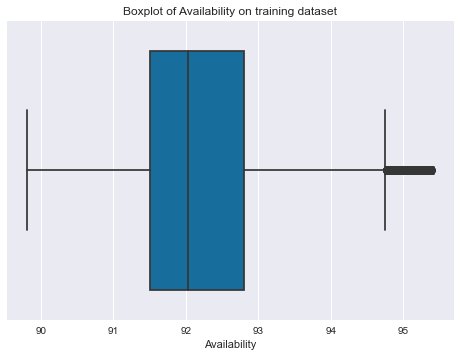

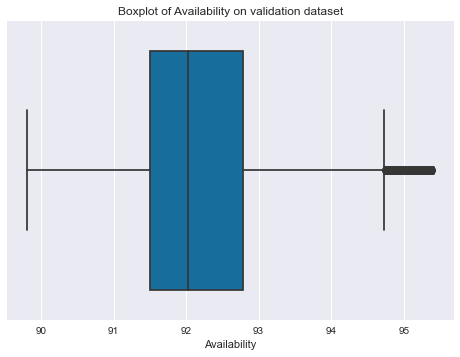

In [29]:
# Checking outliers in training dataset for Availability Variable

plt.title('Boxplot of Availability on training dataset')
sns.boxplot(x=train_data['Availability'])
plt.show()
plt.title('Boxplot of Availability on validation dataset')
sns.boxplot(x=val_data['Availability'])
plt.show()

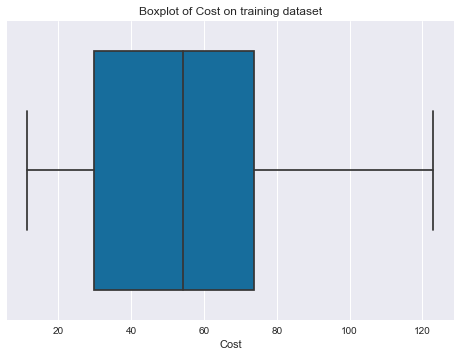

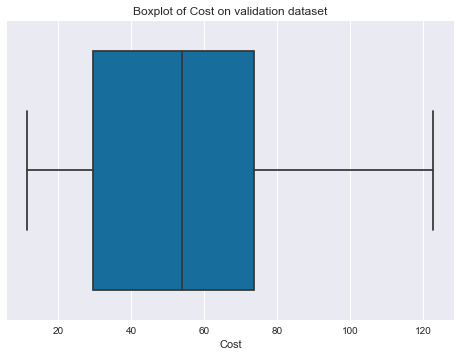

In [30]:
# Checking outliers in training dataset for Cost Variable

plt.title('Boxplot of Cost on training dataset')
sns.boxplot(x=train_data['Cost'])
plt.show()
plt.title('Boxplot of Cost on validation dataset')
sns.boxplot(x=val_data['Cost'])
plt.show()

In [31]:
# Checking skewness of all the variables on training data

for i in train_data.columns:
    if train_data[i].dtypes == 'float64':
        print("The skewness of {} is {}".format(i, train_data[i].skew()))

The skewness of BaseDemand is -0.1796081858474177
The skewness of Demand is -1.1931240146012714
The skewness of Availability is 0.6622784876351108
The skewness of Event is 3.0171923198809156
The skewness of Cost is 0.17799214947772798


In [32]:
# Checking skewness of all the variables on validation data

for i in val_data.columns:
    if val_data[i].dtypes == 'float64':
        print("The skewness of {} is {}".format(i, val_data[i].skew()))

The skewness of BaseDemand is -0.1535257371067564
The skewness of Demand is -1.1908246331338883
The skewness of Availability is 0.6779038208252379
The skewness of Event is 3.024458731910864
The skewness of Cost is 0.17972043140692287


Demand variable is highly skewed so we need to perform data transformation on this. 

### B. Bivariate Analysis

<AxesSubplot:xlabel='BaseDemand', ylabel='Cost'>

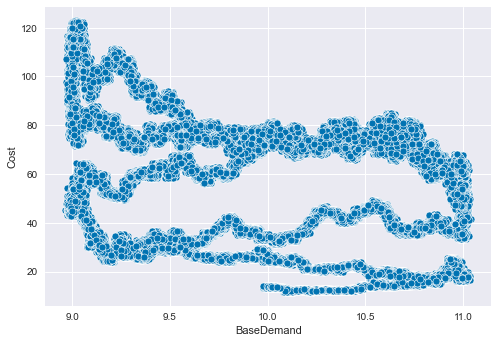

In [33]:
# Checking the impact of BaseDemand variable on Cost

sns.scatterplot(data = train_data, x = "BaseDemand", y = "Cost")

<AxesSubplot:xlabel='Demand', ylabel='Cost'>

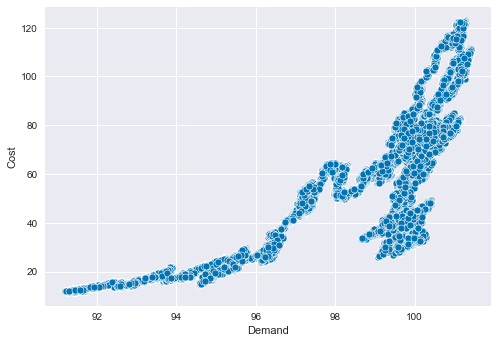

In [34]:
# Checking the impact of Demand variable on Cost

sns.scatterplot(data = train_data, x = "Demand", y = "Cost")

We can infer from the plot that as the Demand increases the price first increases steadily upto a limit and then it it has a varying price at high demand.

<AxesSubplot:xlabel='Availability', ylabel='Cost'>

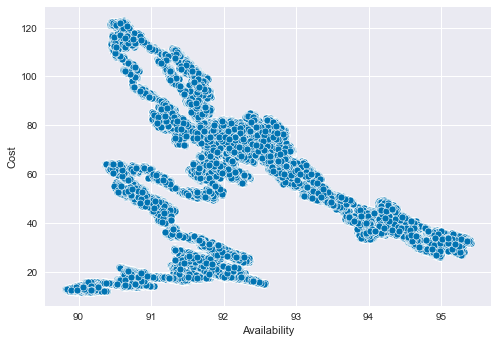

In [35]:
# Checking the impact of Availability variable on Cost

sns.scatterplot(data = train_data, x = "Availability", y = "Cost")

We can infer that when we have moderate availability then the cost is high.

<AxesSubplot:xlabel='Event', ylabel='Cost'>

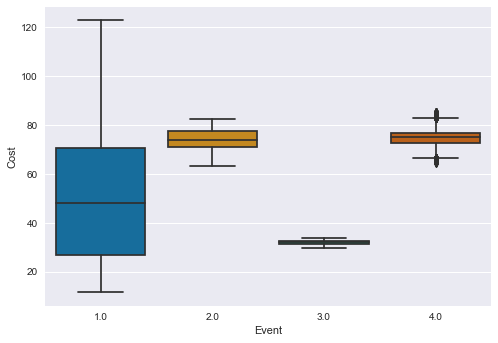

In [36]:
# Checking the impact of BaseDemand variable on Cost

sns.boxplot(data = train_data, x = "Event", y = "Cost")

Event is an important variable to predict cost as depending on event there is a imapcting difference in the cost.

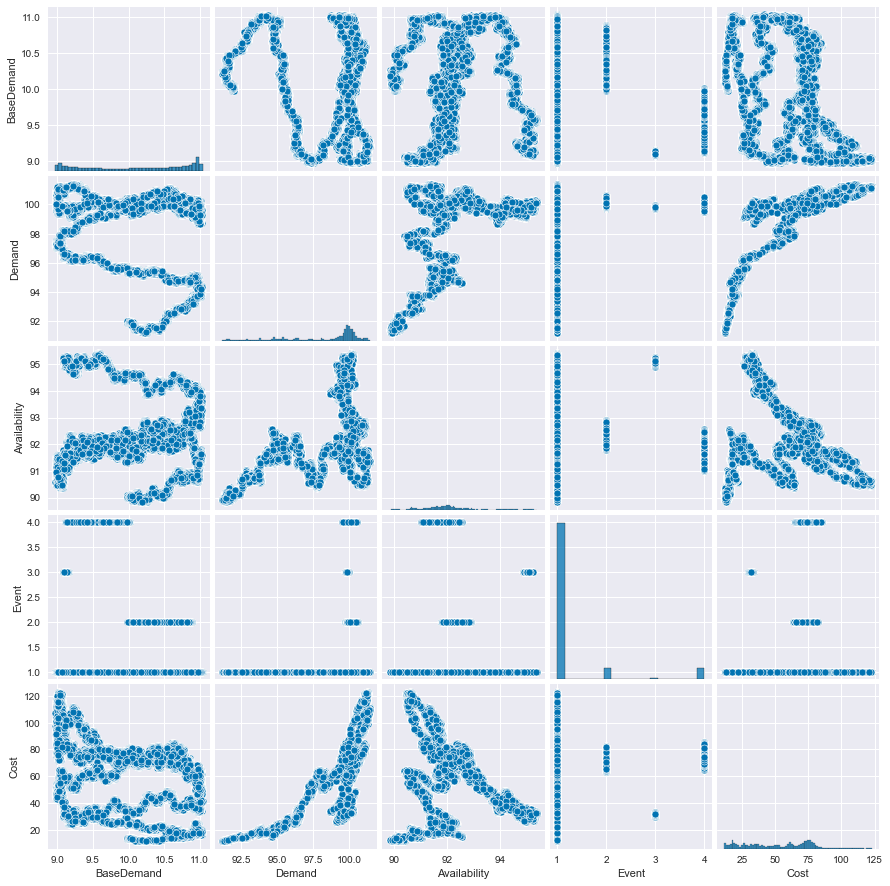

In [37]:
# Checking pair plot on training data

sns.pairplot(data=train_data)

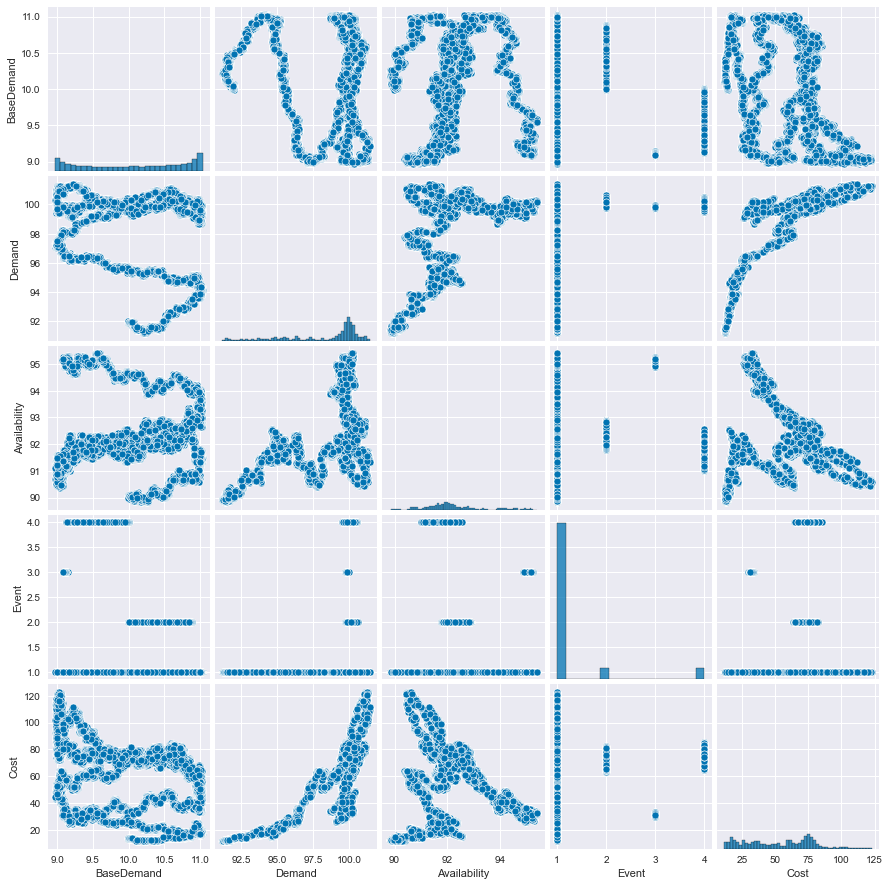

In [38]:
# Checking pair plot on validation data

sns.pairplot(data=val_data)

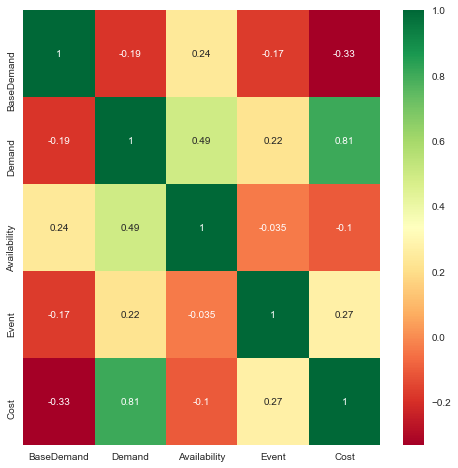

In [39]:
# Correlation Matrix

fig = plt.figure(figsize=(8, 8))
train_data_corr = train_data.corr()
ax = sns.heatmap(train_data_corr, annot = True, cmap = "RdYlGn")

### C. (i) Missing Value Imputation using KNN Imputer

In [62]:
KNN_imputed = pd.read_csv("KNN_imputed.csv")
KNN_imputed_val = pd.read_csv("KNN_imputed_val.csv")

In [41]:
KNN_imputed.isnull().sum()

Date            0
BaseDemand      0
Demand          0
Availability    0
Event           0
Cost            0
dtype: int64

In [42]:
KNN_imputed_val.isnull().sum()

Date            0
BaseDemand      0
Demand          0
Availability    0
Event           0
Cost            0
dtype: int64

In [43]:
KNN_imputed.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
0,20-08-2017 19:50,9.704177,99.524725,91.933723,1.0,44.890070
1,17-12-2015 20:00,9.104771,99.973584,92.958830,1.0,84.436845
2,08-03-2016 04:10,8.996410,100.294082,90.691762,1.0,101.174063
3,23-05-2015 13:20,10.083981,100.129655,92.204510,1.0,72.904463
4,18-10-2018 18:20,9.229405,99.545510,94.680152,1.0,32.878688


In [44]:
KNN_imputed_val.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
0,06-09-2012 22:40,9.570974,97.483679,91.254099,1.0,31.678591
1,06-10-2016 23:30,9.687380,100.274327,91.046785,1.0,78.997001
2,18-12-2014 01:50,10.853262,100.111777,92.505032,1.0,68.843280
3,11-07-2011 15:20,10.894139,97.398988,90.671886,1.0,17.757450
4,21-02-2015 14:00,10.570834,101.097437,92.711364,1.0,81.070106


### C. (ii) KNN Imputer on entire dataset

In [61]:
KNN_imputed2 = pd.read_excel("KNN_imputed_Model5.xlsx")
KNN_imputed_val2 = pd.read_excel("KNN_imputed_val_Model5.xlsx")

In [46]:
KNN_imputed2.isnull().sum()

Date            0
BaseDemand      0
Demand          0
Availability    0
Event           0
Cost            0
dtype: int64

In [47]:
KNN_imputed_val2.isnull().sum()

Date            0
BaseDemand      0
Demand          0
Availability    0
Event           0
Cost            0
dtype: int64

In [48]:
KNN_imputed2.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
0,2015-04-27 13:50:00,10.607848,100.519131,92.762372,1.0,70.631028
1,2011-03-13 09:30:00,10.398790,91.443575,90.206127,1.0,11.957248
2,2016-04-24 17:20:00,9.030626,101.200844,90.668879,1.0,119.613814
3,2017-12-13 01:50:00,10.793890,99.529210,94.247593,1.0,38.682389
4,2018-02-22 22:30:00,10.503808,100.067744,94.166027,1.0,35.178400


In [49]:
KNN_imputed_val2.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
0,2014-07-05 10:00:00,10.929912,97.165812,92.784284,1.0,50.928738
1,2016-08-08 04:30:00,9.714897,100.973942,91.749919,1.6,94.375101
2,2016-03-23 00:30:00,9.001993,100.066617,90.617193,1.0,46.889773
3,2014-04-20 17:40:00,10.659619,100.306821,92.562589,2.0,68.026017
4,2011-09-16 11:40:00,10.993775,96.255259,91.354885,1.0,17.178526


### C. (iii) MICE Imputation

In [50]:
notnull_data.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
4,2011-01-01 00:50:00,9.991615,92.001876,89.993375,1.0,14.000028
5,2011-01-01 01:00:00,9.997209,91.999315,NaN,1.0,13.973751
6,2011-01-01 01:10:00,9.977525,91.997062,90.004419,NaN,14.008853
7,2011-01-01 01:20:00,10.007896,91.996860,89.996370,NaN,13.985555
8,2011-01-01 01:30:00,NaN,NaN,89.992017,1.0,14.015692


In [51]:
X_data = notnull_data[['BaseDemand','Demand','Availability','Event']]

In [63]:
completed_data = pd.read_csv("MICE_imputed.csv")

In [53]:
completed_data.head()

,Date,BaseDemand,Demand,Availability,Event,Cost
0,01-01-2011 00:50,9.991615,92.001876,89.993375,1,14.000028
1,01-01-2011 01:00,9.997209,91.999315,90.002085,1,13.973751
2,01-01-2011 01:10,9.977525,91.997062,90.004419,1,14.008853
3,01-01-2011 01:20,10.007896,91.996860,89.996370,1,13.985555
4,01-01-2011 01:30,10.117859,91.651068,89.992017,1,14.015692


### D. Feature Engineering

We will seperate the date column into different columns like: Date, Month, Year, Hour and Minutes.

In [64]:
KNN_imputed1 = KNN_imputed.copy()

KNN_imputed1['Date'] = pd.DataFrame(pd.to_datetime(KNN_imputed1['Date'],dayfirst=True))
KNN_imputed1['Year'] = KNN_imputed1['Date'].dt.year
KNN_imputed1['Month'] = KNN_imputed1['Date'].dt.month
KNN_imputed1['Date1'] = KNN_imputed1['Date'].dt.day
KNN_imputed1['Hour'] = KNN_imputed1['Date'].dt.hour
KNN_imputed1['Minute'] = KNN_imputed1['Date'].dt.minute

In [65]:
KNN_imputed_val1 = KNN_imputed_val.copy()

KNN_imputed_val1['Date'] = pd.DataFrame(pd.to_datetime(KNN_imputed_val1['Date'],dayfirst=True))
KNN_imputed_val1['Year'] = KNN_imputed_val1['Date'].dt.year
KNN_imputed_val1['Month'] = KNN_imputed_val1['Date'].dt.month
KNN_imputed_val1['Date1'] = KNN_imputed_val1['Date'].dt.day
KNN_imputed_val1['Hour'] = KNN_imputed_val1['Date'].dt.hour
KNN_imputed_val1['Minute'] = KNN_imputed_val1['Date'].dt.minute

In [66]:
KNN_imputed3 = KNN_imputed2.copy()

KNN_imputed3['Date'] = pd.DataFrame(pd.to_datetime(KNN_imputed3['Date'],dayfirst=True))
KNN_imputed3['Year'] = KNN_imputed3['Date'].dt.year
KNN_imputed3['Month'] = KNN_imputed3['Date'].dt.month
KNN_imputed3['Date1'] = KNN_imputed3['Date'].dt.day
KNN_imputed3['Hour'] = KNN_imputed3['Date'].dt.hour
KNN_imputed3['Minute'] = KNN_imputed3['Date'].dt.minute

In [67]:
KNN_imputed_val3 = KNN_imputed_val.copy()

KNN_imputed_val3['Date'] = pd.DataFrame(pd.to_datetime(KNN_imputed_val3['Date'],dayfirst=True))
KNN_imputed_val3['Year'] = KNN_imputed_val3['Date'].dt.year
KNN_imputed_val3['Month'] = KNN_imputed_val3['Date'].dt.month
KNN_imputed_val3['Date1'] = KNN_imputed_val3['Date'].dt.day
KNN_imputed_val3['Hour'] = KNN_imputed_val3['Date'].dt.hour
KNN_imputed_val3['Minute'] = KNN_imputed_val3['Date'].dt.minute

In [68]:
MICE_data = completed_data.copy()

MICE_data['Date'] = pd.DataFrame(pd.to_datetime(MICE_data['Date'],dayfirst=True))
MICE_data['Year'] = MICE_data['Date'].dt.year
MICE_data['Month'] = MICE_data['Date'].dt.month
MICE_data['Date1'] = MICE_data['Date'].dt.day
MICE_data['Hour'] = MICE_data['Date'].dt.hour
MICE_data['Minute'] = MICE_data['Date'].dt.minute

In [69]:
# Removing original date column

KNN_imputed1 = KNN_imputed1.drop('Date', axis =1)
KNN_imputed_val1 = KNN_imputed_val1.drop('Date', axis =1)

KNN_imputed3 = KNN_imputed3.drop('Date', axis =1)
KNN_imputed_val3 = KNN_imputed_val3.drop('Date', axis =1)

MICE_data = MICE_data.drop('Date', axis =1)

## Model 1: Using KNN Imputed Values

In [70]:
X_train_KNN = KNN_imputed1.drop('Cost',axis = 1)
Y_train_KNN = KNN_imputed1[['Cost']]

X_val_KNN = KNN_imputed_val1.drop('Cost',axis = 1)
Y_val_KNN = KNN_imputed_val1[['Cost']]

In [71]:
X_train_KNN.shape

(250000, 9)

In [72]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor()
model1.fit(X_train_KNN, Y_train_KNN)

<ipython-input-72-47d2d06d8c78>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X_train_KNN, Y_train_KNN)


RandomForestRegressor()

In [73]:
Y_train_pred = model1.predict(X_train_KNN)
r2_Model1_train = (r2_score(Y_train_KNN, Y_train_pred))*100
print(r2_Model1_train)

99.99534674872362


In [74]:
# Model 1 Training data metrics

print('MAE:', metrics.mean_absolute_error(Y_train_KNN, Y_train_pred))
print('MSE:', metrics.mean_squared_error(Y_train_KNN, Y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_KNN, Y_train_pred)))
MSE_Model1_train = metrics.mean_squared_error(Y_train_KNN, Y_train_pred)

MAE: 0.07435526973245565
MSE: 0.03075406170182131
RMSE: 0.1753683600362999


In [75]:
Y_val_pred = model1.predict(X_val_KNN)
r2_Model1_val = r2_score(Y_val_KNN, Y_val_pred)
print(r2_Model1_val)

0.9994495214996667


In [76]:
# Model 1 Validation data metrics

print('MAE:', metrics.mean_absolute_error(Y_val_KNN, Y_val_pred))
print('MSE:', metrics.mean_squared_error(Y_val_KNN, Y_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_KNN, Y_val_pred)))
MSE_Model1_val = metrics.mean_squared_error(Y_val_KNN, Y_val_pred)

MAE: 0.20920204357374553
MSE: 0.3646027790073448
RMSE: 0.6038234667577477


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


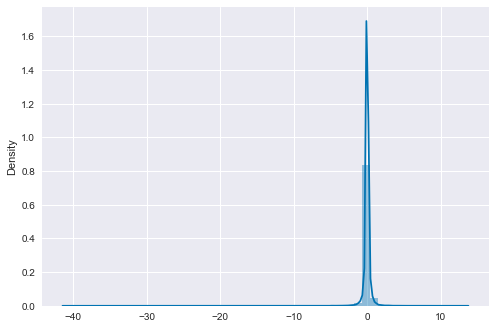

In [77]:
# Residual Plot

Y_val_pred = Y_val_pred.reshape(-1,1)
sns.distplot(Y_val_KNN - Y_val_pred)
plt.show()

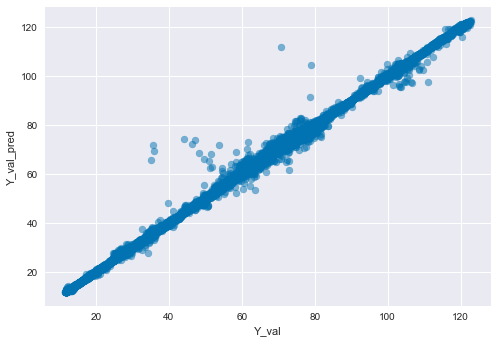

In [78]:
plt.scatter(Y_val_KNN, Y_val_pred, alpha = 0.5)
plt.xlabel("Y_val")
plt.ylabel("Y_val_pred")
plt.show()

In [79]:
# Saving Model1 in file

pickle.dump(model1,open('model1.sav','wb'))

## Model 2: Hyper Parameter tuning on Model 1

In [81]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [82]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations

model2 = RandomizedSearchCV(estimator = model1, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [ ]:
model2.fit(X_train_KNN,Y_train_KNN)

In [ ]:
model2.best_params_

In [ ]:
Y_train_pred = model2.predict(X_train_KNN)

In [ ]:
# Metrics on training data

print('MAE:', metrics.mean_absolute_error(Y_train_KNN, Y_train_pred))
print('MSE:', metrics.mean_squared_error(Y_train_KNN, Y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_KNN, Y_train_pred)))
MSE_Model2_train = metrics.mean_squared_error(Y_train_KNN, Y_train_pred)

In [ ]:
Y_val_pred = model2.predict(X_val_KNN)

In [ ]:
# Metrics on validation data

print('MAE:', metrics.mean_absolute_error(Y_val_KNN, Y_val_pred))
print('MSE:', metrics.mean_squared_error(Y_val_KNN, Y_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_KNN, Y_val_pred)))
MSE_Model2_val = metrics.mean_squared_error(Y_val_KNN, Y_val_pred)

In [ ]:
Y_val_pred = Y_val_pred.reshape(-1,1)
plt.figure(figsize = (8,8))
sns.distplot(Y_val_KNN-Y_val_pred)
plt.show()

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(Y_val_KNN, Y_val_pred, alpha = 0.5)
plt.xlabel("Y_val_KNN")
plt.ylabel("Y_val_pred")
plt.show()

In [ ]:
pickle.dump(model2,open('model2.sav','wb'))

### Model 3: MICE Imputated Dataset

In [83]:
train_data, val_data = train_test_split(MICE_data, test_size = 0.2 , random_state = 10)

X_train_MICE = train_data.drop('Cost',axis = 1)
Y_train_MICE = train_data[['Cost']]

X_val_MICE = val_data.drop('Cost',axis = 1)
Y_val_MICE = val_data[['Cost']]

In [84]:
from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor()
model3.fit(X_train_MICE, Y_train_MICE)

<ipython-input-84-e08d1004fb25>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3.fit(X_train_MICE, Y_train_MICE)


RandomForestRegressor()

In [85]:
Y_train_MICE_pred = model3.predict(X_train_MICE)
r2_Model3_train = (r2_score(Y_train_MICE, Y_train_MICE_pred))*100
print(r2_Model3_train)

99.98796499522243


In [86]:
# Metrics on training data

print('MAE:', metrics.mean_absolute_error(Y_train_MICE, Y_train_MICE_pred))
print('MSE:', metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred)))
MSE_Model3_train = metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred)

MAE: 0.11332403746066455
MSE: 0.07954121914490114
RMSE: 0.28203052874627094


In [87]:
Y_val_MICE_pred = model3.predict(X_val_MICE)
r2_Model3_val = (r2_score(Y_val_MICE, Y_val_MICE_pred))*100
print(r2_Model3_val)

99.92005031389056


In [88]:
# Metrics on validation data

print('MAE:', metrics.mean_absolute_error(Y_val_MICE, Y_val_MICE_pred))
print('MSE:', metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred)))
MSE_Model3_val = metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred)

MAE: 0.2995152470579405
MSE: 0.5295370794429944
RMSE: 0.7276929843299264


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


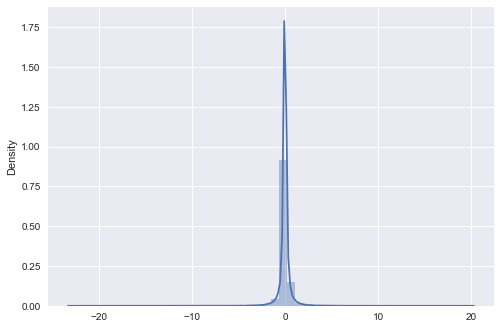

In [89]:
# Residual Plot

Y_val_MICE_pred = Y_val_MICE_pred.reshape(-1,1)
sns.distplot(Y_val_MICE - Y_val_MICE_pred)
plt.show()

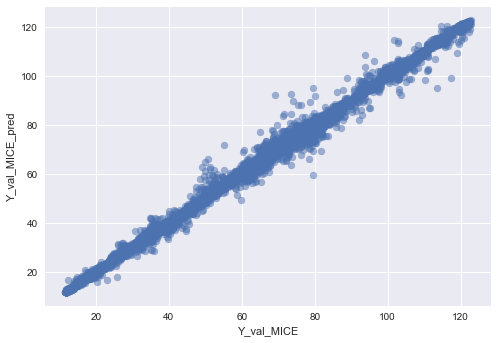

In [90]:
plt.scatter(Y_val_MICE, Y_val_MICE_pred, alpha = 0.5)
plt.xlabel("Y_val_MICE")
plt.ylabel("Y_val_MICE_pred")
plt.show()

In [91]:
pickle.dump(model3,open('model3.sav','wb'))

### Model 4: MICE Imputed Dataset and Robust Scaler

In [92]:
train_data.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
261768,9.967928,99.524725,94.989870,1,44.890070,2017,8,20,19,50
195882,9.104771,99.973584,91.264973,1,84.436845,2015,12,17,20,0
204617,8.996410,100.294082,90.691762,1,101.174063,2016,3,8,4,10
173278,10.083981,100.129655,92.204510,1,72.904463,2015,5,23,13,20
307449,9.229405,99.545510,94.680152,1,32.878688,2018,10,18,18,20


In [93]:
val_data.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
66408,9.570974,99.292469,91.869361,1,31.678591,2012,9,6,22,40
227653,9.687380,100.274327,91.958183,1,78.997001,2016,10,6,23,30
156371,10.853262,100.111777,92.505032,1,68.843280,2014,12,18,1,50
20617,10.894139,93.819605,90.671886,1,17.757450,2011,7,11,15,20
163430,10.570834,101.097437,92.711364,1,81.070106,2015,2,21,14,0


In [94]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [95]:
col_names = ['BaseDemand', 'Demand','Availability']

train_scaled = train_data.copy()
val_scaled = val_data.copy()

train_features = train_scaled[col_names]
val_features = val_scaled[col_names]

In [96]:
train_scaled[col_names] = scaler.fit_transform(train_features.values)
train_scaled.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
261768,-0.148232,-0.055491,2.303836,1,44.890070,2017,8,20,19,50
195882,-0.788170,0.073844,-0.599250,1,84.436845,2015,12,17,20,0
204617,-0.868508,0.166194,-1.045995,1,101.174063,2016,3,8,4,10
173278,-0.062191,0.118815,0.133001,1,72.904463,2015,5,23,13,20
307449,-0.695767,-0.049502,2.062451,1,32.878688,2018,10,18,18,20


In [97]:
train_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BaseDemand,250000.0,-0.061315,0.512469,-0.891544,-0.562183,0.000000e+00,0.437817,0.646470
Demand,250000.0,-0.367863,0.732044,-2.457014,-0.882382,0.000000e+00,0.117618,0.492138
Availability,250000.0,0.183152,0.949351,-1.728577,-0.403347,5.537782e-15,0.596653,2.634562
Event,250000.0,1.253004,0.749589,1.000000,1.000000,1.000000e+00,1.000000,4.000000
Cost,250000.0,52.907146,25.708329,11.525820,29.686697,5.411804e+01,73.726808,122.975852
Year,250000.0,2014.465524,2.274078,2011.000000,2012.000000,2.014000e+03,2016.000000,2018.000000
Month,250000.0,6.469712,3.421433,1.000000,4.000000,6.000000e+00,9.000000,12.000000
Date1,250000.0,15.704248,8.803131,1.000000,8.000000,1.600000e+01,23.000000,31.000000
Hour,250000.0,11.491388,6.926758,0.000000,5.000000,1.100000e+01,17.000000,23.000000
Minute,250000.0,25.021000,17.064487,0.000000,10.000000,2.000000e+01,40.000000,50.000000


In [98]:
val_scaled[col_names] = scaler.fit_transform(val_features.values)
val_scaled.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
66408,-0.426928,-0.119501,-0.120979,1,31.678591,2012,9,6,22,40
227653,-0.341037,0.160143,-0.051518,1,78.997001,2016,10,6,23,30
156371,0.519215,0.113847,0.376137,1,68.843280,2014,12,18,1,50
20617,0.549376,-1.678233,-1.057445,1,17.757450,2011,7,11,15,20
163430,0.310824,0.394574,0.537496,1,81.070106,2015,2,21,14,0


In [99]:
val_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BaseDemand,62500.0,-0.055066,0.510791,-0.869881,-0.555465,-6.553469e-16,0.444535,0.650338
Demand,62500.0,-0.363414,0.724051,-2.427106,-0.882108,0.000000e+00,0.117892,0.486497
Availability,62500.0,0.183845,0.952814,-1.729171,-0.403096,5.556685e-15,0.596904,2.646624
Event,62500.0,1.252720,0.751104,1.000000,1.000000,1.000000e+00,1.000000,4.000000
Cost,62500.0,52.870746,25.736132,11.566570,29.526158,5.405793e+01,73.805460,122.876846
Year,62500.0,2014.456928,2.278456,2011.000000,2012.000000,2.014000e+03,2016.000000,2018.000000
Month,62500.0,6.486864,3.420072,1.000000,4.000000,7.000000e+00,9.000000,12.000000
Date1,62500.0,15.748864,8.814332,1.000000,8.000000,1.600000e+01,23.000000,31.000000
Hour,62500.0,11.510384,6.924713,0.000000,6.000000,1.100000e+01,18.000000,23.000000
Minute,62500.0,24.949920,17.123568,0.000000,10.000000,2.000000e+01,40.000000,50.000000


In [100]:
# Defining X and Y

X_train_MICE = train_scaled.drop('Cost',axis = 1)
Y_train_MICE = train_scaled[['Cost']]

X_val_MICE = val_scaled.drop('Cost',axis = 1)
Y_val_MICE = val_scaled[['Cost']]

In [101]:
from sklearn.ensemble import RandomForestRegressor
model4 = RandomForestRegressor()
model4.fit(X_train_MICE, Y_train_MICE)

<ipython-input-101-8bb0dd838684>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4.fit(X_train_MICE, Y_train_MICE)


RandomForestRegressor()

In [102]:
# Predictions on training data

Y_train_MICE_pred = model4.predict(X_train_MICE)
r2_Model4_train = (r2_score(Y_train_MICE, Y_train_MICE_pred))*100
print(r2_Model4_train)

99.98836525880884


In [103]:
# Metrics of training data

print('MAE:', metrics.mean_absolute_error(Y_train_MICE, Y_train_MICE_pred))
print('MSE:', metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred)))
MSE_Model4_train = metrics.mean_squared_error(Y_train_MICE, Y_train_MICE_pred)

MAE: 0.11289709736559934
MSE: 0.07689581482379039
RMSE: 0.27730094630886204


In [104]:
# Predictions on validation data

Y_val_MICE_pred = model4.predict(X_val_MICE)
r2_Model4_val = r2_score(Y_val_MICE, Y_val_MICE_pred)
print(r2_Model4_val)

0.9990933124364123


In [105]:
# Metrics of validation data

print('MAE:', metrics.mean_absolute_error(Y_val_MICE, Y_val_MICE_pred))
print('MSE:', metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred)))
MSE_Model4_val = metrics.mean_squared_error(Y_val_MICE, Y_val_MICE_pred)

MAE: 0.35737011384236245
MSE: 0.600533545225344
RMSE: 0.7749409946733647


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


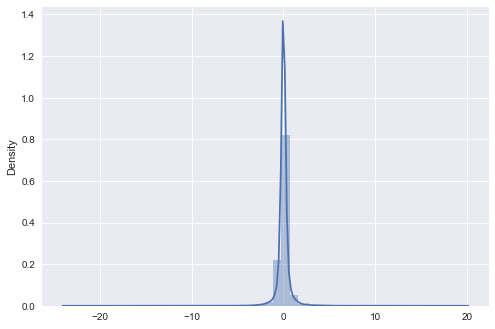

In [106]:
# Residual Plot

Y_val_MICE_pred = Y_val_MICE_pred.reshape(-1,1)
sns.distplot(Y_val_MICE - Y_val_MICE_pred)
plt.show()

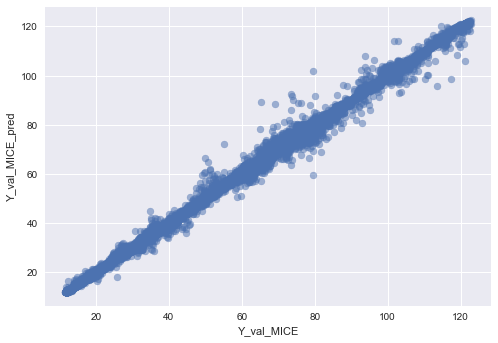

In [107]:
plt.scatter(Y_val_MICE, Y_val_MICE_pred, alpha = 0.5)
plt.xlabel("Y_val_MICE")
plt.ylabel("Y_val_MICE_pred")
plt.show()

In [108]:
# Saving model in file

pickle.dump(model4,open('model4.sav','wb'))

### Model 5: KNN Imputer on entire dataset ('Cost')

In [109]:
KNN_imputed3.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
0,10.607848,100.519131,92.762372,1.0,70.631028,2015,4,27,13,50
1,10.398790,91.443575,90.206127,1.0,11.957248,2011,3,13,9,30
2,9.030626,101.200844,90.668879,1.0,119.613814,2016,4,24,17,20
3,10.793890,99.529210,94.247593,1.0,38.682389,2017,12,13,1,50
4,10.503808,100.067744,94.166027,1.0,35.178400,2018,2,22,22,30


In [110]:
KNN_imputed_val3.head()

,BaseDemand,Demand,Availability,Event,Cost,Year,Month,Date1,Hour,Minute
0,9.570974,97.483679,91.254099,1.0,31.678591,2012,9,6,22,40
1,9.687380,100.274327,91.046785,1.0,78.997001,2016,10,6,23,30
2,10.853262,100.111777,92.505032,1.0,68.843280,2014,12,18,1,50
3,10.894139,97.398988,90.671886,1.0,17.757450,2011,7,11,15,20
4,10.570834,101.097437,92.711364,1.0,81.070106,2015,2,21,14,0


In [111]:
X_train_KNN = KNN_imputed3.drop('Cost',axis = 1)
Y_train_KNN = KNN_imputed3[['Cost']]

X_val_KNN = KNN_imputed_val3.drop('Cost',axis = 1)
Y_val_KNN = KNN_imputed_val3[['Cost']]

In [112]:
model5 = RandomForestRegressor()
model5.fit(X_train_KNN, Y_train_KNN)

<ipython-input-112-a7a5e3195595>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model5.fit(X_train_KNN, Y_train_KNN)


RandomForestRegressor()

In [113]:
Y_train_pred = model5.predict(X_train_KNN)
r2_Model5_train = (r2_score(Y_train_KNN, Y_train_pred))*100
print(r2_Model5_train)

96.09332992228656


In [114]:
# Metrics on training data

print('MAE:', metrics.mean_absolute_error(Y_train_KNN, Y_train_pred))
print('MSE:', metrics.mean_squared_error(Y_train_KNN, Y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_KNN, Y_train_pred)))
MSE_Model5_train = metrics.mean_squared_error(Y_train_KNN, Y_train_pred)

MAE: 3.0318766314026337
MSE: 21.51512684278092
RMSE: 4.638440130343489


In [115]:
Y_val_pred = model5.predict(X_val_KNN)
r2_Model5_val = (r2_score(Y_val_KNN, Y_val_pred))*100
print(r2_Model5_val)

95.01419383977256


In [116]:
# Metrics on validation data

print('MAE:', metrics.mean_absolute_error(Y_val_KNN, Y_val_pred))
print('MSE:', metrics.mean_squared_error(Y_val_KNN, Y_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_KNN, Y_val_pred)))
MSE_Model5_val = metrics.mean_squared_error(Y_val_KNN, Y_val_pred)

MAE: 3.959875761323928
MSE: 33.02288428177119
RMSE: 5.746554122408592


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


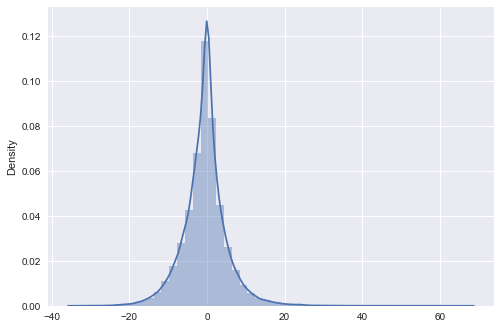

In [117]:
# Residual Plot

Y_val_pred = Y_val_pred.reshape(-1,1)
sns.distplot(Y_val_KNN - Y_val_pred)
plt.show()

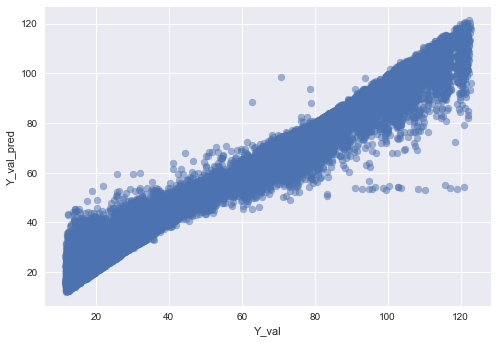

In [118]:
plt.scatter(Y_val_KNN, Y_val_pred, alpha = 0.5)
plt.xlabel("Y_val")
plt.ylabel("Y_val_pred")
plt.show()

In [119]:
# Saving model in file

pickle.dump(model5,open('model5.sav','wb'))

### Model 6: KNN Imputer and XGBoost Model

In [120]:
X_train_KNN = KNN_imputed1.drop('Cost',axis = 1)
Y_train_KNN = KNN_imputed1[['Cost']]

X_val_KNN = KNN_imputed_val1.drop('Cost',axis = 1)
Y_val_KNN = KNN_imputed_val1[['Cost']]

In [121]:
model6 = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model6, X_train_KNN, Y_train_KNN, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# fit the model on the whole dataset
model6 = XGBRegressor(objective='reg:squarederror')
model6.fit(X_train_KNN, Y_train_KNN)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [122]:
Y_train_pred = model6.predict(X_train_KNN)
r2_Model6_train = (r2_score(Y_train_pred, Y_train_KNN))*100
print(r2_Model6_train)

99.76058989664334


In [123]:
# Metrics on training data

print('MAE:', metrics.mean_absolute_error(Y_train_KNN, Y_train_pred))
print('MSE:', metrics.mean_squared_error(Y_train_KNN, Y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_KNN, Y_train_pred)))
MSE_Model6_train = metrics.mean_squared_error(Y_train_KNN, Y_train_pred)

MAE: 0.8044090923848641
MSE: 1.574673262168753
RMSE: 1.2548598575812173


In [124]:
Y_val_pred = model6.predict(X_val_KNN)

In [125]:
# Metrics on validation data

print('MAE:', metrics.mean_absolute_error(Y_val_KNN, Y_val_pred))
print('MSE:', metrics.mean_squared_error(Y_val_KNN, Y_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val_KNN, Y_val_pred)))
MSE_Model6_val = metrics.mean_squared_error(Y_val_KNN, Y_val_pred)

MAE: 0.8442249748146924
MSE: 1.8429898805321796
RMSE: 1.3575676338702907


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


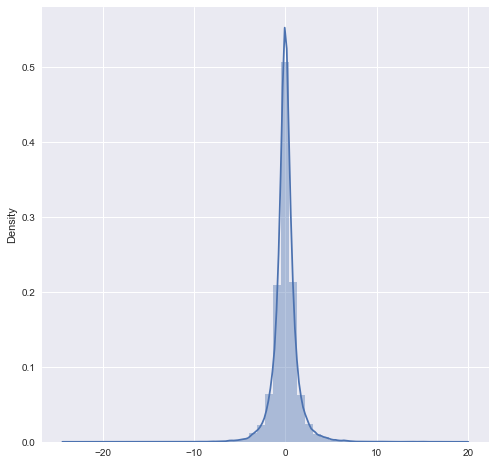

In [126]:
Y_val_pred = Y_val_pred.reshape(-1,1)
plt.figure(figsize = (8,8))
sns.distplot(Y_val_KNN-Y_val_pred)
plt.show()

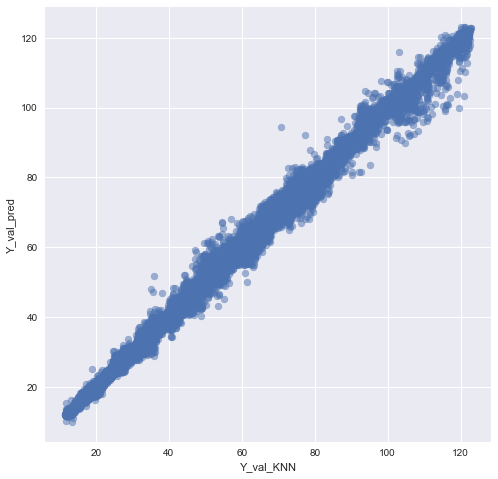

In [127]:
plt.figure(figsize = (8,8))
plt.scatter(Y_val_KNN, Y_val_pred, alpha = 0.5)
plt.xlabel("Y_val_KNN")
plt.ylabel("Y_val_pred")
plt.show()

In [128]:
# Saving model in file

pickle.dump(model6,open('model6.sav','wb'))

## Comparing Model Performances

In [129]:
print(MSE_Model1_train)
print(MSE_Model1_val)
print(r2_Model1_train)

0.03075406170182131
0.3646027790073448
99.99534674872362


In [ ]:
print(MSE_Model2_train)
print(MSE_Model2_val)
#print(r2_Model2_train)

In [130]:
print(MSE_Model3_train)
print(MSE_Model3_val)
print(r2_Model3_train)

0.07954121914490114
0.5295370794429944
99.98796499522243


In [131]:
print(MSE_Model4_train)
print(MSE_Model4_val)
print(r2_Model4_train)

0.07689581482379039
0.600533545225344
99.98836525880884


In [132]:
print(MSE_Model5_train)
print(MSE_Model5_val)
print(r2_Model5_train)

21.51512684278092
33.02288428177119
96.09332992228656


In [133]:
print(MSE_Model6_train)
print(MSE_Model6_val)
print(r2_Model6_train)

1.574673262168753
1.8429898805321796
99.76058989664334
